In [60]:
import matplotlib as mpl
from numpy import *
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
#mpl.use('Agg')

In [61]:
# 设置GPU内存按需分配
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [62]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [119]:
def build_network():
    # 先创建包含多网络层的列表
    conv_layers = [
        #layers.Embedding(21, 5, input_length=input_len),
        #layers.LSTM(128,return_sequences = True),
        layers.LSTM(128,return_sequences = True),
        layers.LSTM(256,return_sequences = True)
        
    ]

    fc_layers = [
        layers.Flatten(),
        layers.Dense(32, activation=tf.nn.relu),  # 全连接层， 32 个节点
        layers.Dense(1, activation=tf.nn.sigmoid)  # 全连接层， 1 个节点
    ]

    conv_layers.extend(fc_layers)
    network = Sequential(conv_layers)
    network.build(input_shape=[None, 41,21])
    #network.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    base_learning_rate = 0.001
    network.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])
    network.summary()

    return network

In [120]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [148]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
batch_size=512
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [149]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [150]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [151]:
prediction_result_cv = []
prediction_result_ind = []

In [152]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH')

In [153]:
out = os.getcwd() + '\\'
input_shape = len(x_train[0])

In [154]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    network = build_network()
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = network.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = network.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = network.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 41, 128)           76800     
_________________________________________________________________
lstm_101 (LSTM)              (None, 41, 256)           394240    
_________________________________________________________________
flatten_50 (Flatten)         (None, 10496)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 32)                335904    
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 33        
Total params: 806,977
Trainable params: 806,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
4/4 - 2s - loss: 0.7091 - accuracy: 0.5269 - val_loss: 0.6800 - val_accuracy: 0.5689

Epoch 00001: va

4/4 - 0s - loss: 0.4121 - accuracy: 0.8043 - val_loss: 0.7116 - val_accuracy: 0.6311

Epoch 00041: val_loss did not improve from 0.56882
Epoch 42/300
4/4 - 0s - loss: 0.4046 - accuracy: 0.8141 - val_loss: 0.6660 - val_accuracy: 0.6844

Epoch 00042: val_loss did not improve from 0.56882
Epoch 43/300
4/4 - 0s - loss: 0.3752 - accuracy: 0.8275 - val_loss: 0.7803 - val_accuracy: 0.6578

Epoch 00043: val_loss did not improve from 0.56882
Epoch 44/300
4/4 - 0s - loss: 0.4502 - accuracy: 0.7929 - val_loss: 0.5844 - val_accuracy: 0.7067

Epoch 00044: val_loss did not improve from 0.56882
Epoch 45/300
4/4 - 0s - loss: 0.3724 - accuracy: 0.8408 - val_loss: 0.6691 - val_accuracy: 0.6756

Epoch 00045: val_loss did not improve from 0.56882
Epoch 46/300
4/4 - 0s - loss: 0.3509 - accuracy: 0.8463 - val_loss: 0.7455 - val_accuracy: 0.6800

Epoch 00046: val_loss did not improve from 0.56882
Epoch 47/300
4/4 - 0s - loss: 0.3547 - accuracy: 0.8408 - val_loss: 0.6820 - val_accuracy: 0.6756

Epoch 00047: v

4/4 - 2s - loss: 0.7631 - accuracy: 0.5111 - val_loss: 0.6843 - val_accuracy: 0.5156

Epoch 00001: val_loss improved from inf to 0.68435, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_1.h5
Epoch 2/300
4/4 - 0s - loss: 0.6752 - accuracy: 0.5660 - val_loss: 0.6885 - val_accuracy: 0.5289

Epoch 00002: val_loss did not improve from 0.68435
Epoch 3/300
4/4 - 0s - loss: 0.6696 - accuracy: 0.5882 - val_loss: 0.6636 - val_accuracy: 0.6267

Epoch 00003: val_loss improved from 0.68435 to 0.66361, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_1.h5
Epoch 4/300
4/4 - 0s - loss: 0.6693 - accuracy: 0.5937 - val_loss: 0.6525 - val_accuracy: 0.6622

Epoch 00004: val_loss improved from 0.66361 to 0.65250, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_1.h5
Epoch 5/300
4/4 - 0s - loss: 0.6395 - accuracy: 0.6377 - val_loss: 0.6299 - val_accuracy: 0.6978

E


Epoch 00048: val_loss did not improve from 0.57311
Epoch 49/300
4/4 - 0s - loss: 0.3256 - accuracy: 0.8616 - val_loss: 0.7907 - val_accuracy: 0.6267

Epoch 00049: val_loss did not improve from 0.57311
Epoch 50/300
4/4 - 0s - loss: 0.3506 - accuracy: 0.8438 - val_loss: 0.7165 - val_accuracy: 0.6711

Epoch 00050: val_loss did not improve from 0.57311
Epoch 51/300
4/4 - 0s - loss: 0.2947 - accuracy: 0.8715 - val_loss: 0.7357 - val_accuracy: 0.6489

Epoch 00051: val_loss did not improve from 0.57311
Epoch 52/300
4/4 - 0s - loss: 0.2944 - accuracy: 0.8774 - val_loss: 0.7226 - val_accuracy: 0.6978

Epoch 00052: val_loss did not improve from 0.57311
Epoch 53/300
4/4 - 0s - loss: 0.2583 - accuracy: 0.8942 - val_loss: 0.8798 - val_accuracy: 0.6622

Epoch 00053: val_loss did not improve from 0.57311
Epoch 54/300
4/4 - 0s - loss: 0.2897 - accuracy: 0.8651 - val_loss: 0.8059 - val_accuracy: 0.6489

Epoch 00054: val_loss did not improve from 0.57311
Epoch 55/300
4/4 - 0s - loss: 0.2708 - accuracy:


Epoch 00023: val_loss did not improve from 0.63297
Epoch 24/300
4/4 - 0s - loss: 0.5268 - accuracy: 0.7242 - val_loss: 0.7073 - val_accuracy: 0.6222

Epoch 00024: val_loss did not improve from 0.63297
Epoch 25/300
4/4 - 0s - loss: 0.5180 - accuracy: 0.7439 - val_loss: 0.6767 - val_accuracy: 0.6222

Epoch 00025: val_loss did not improve from 0.63297
Epoch 26/300
4/4 - 0s - loss: 0.4909 - accuracy: 0.7588 - val_loss: 0.7285 - val_accuracy: 0.6089

Epoch 00026: val_loss did not improve from 0.63297
Epoch 27/300
4/4 - 0s - loss: 0.4972 - accuracy: 0.7543 - val_loss: 0.7031 - val_accuracy: 0.6444

Epoch 00027: val_loss did not improve from 0.63297
Epoch 28/300
4/4 - 0s - loss: 0.5168 - accuracy: 0.7306 - val_loss: 0.6687 - val_accuracy: 0.6311

Epoch 00028: val_loss did not improve from 0.63297
Epoch 29/300
4/4 - 0s - loss: 0.4965 - accuracy: 0.7563 - val_loss: 0.6764 - val_accuracy: 0.6222

Epoch 00029: val_loss did not improve from 0.63297
Epoch 30/300
4/4 - 0s - loss: 0.4727 - accuracy:

4/4 - 2s - loss: 0.7051 - accuracy: 0.5057 - val_loss: 0.6870 - val_accuracy: 0.5022

Epoch 00001: val_loss improved from inf to 0.68701, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_3.h5
Epoch 2/300
4/4 - 0s - loss: 0.6738 - accuracy: 0.5531 - val_loss: 0.6838 - val_accuracy: 0.5556

Epoch 00002: val_loss improved from 0.68701 to 0.68378, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_3.h5
Epoch 3/300
4/4 - 0s - loss: 0.6639 - accuracy: 0.5976 - val_loss: 0.6654 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.68378 to 0.66543, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_3.h5
Epoch 4/300
4/4 - 0s - loss: 0.6337 - accuracy: 0.6357 - val_loss: 0.6582 - val_accuracy: 0.5956

Epoch 00004: val_loss improved from 0.66543 to 0.65816, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_O


Epoch 00051: val_loss did not improve from 0.64297
Epoch 52/300
4/4 - 0s - loss: 0.2707 - accuracy: 0.8893 - val_loss: 0.9441 - val_accuracy: 0.6444

Epoch 00052: val_loss did not improve from 0.64297
Epoch 53/300
4/4 - 0s - loss: 0.2661 - accuracy: 0.8794 - val_loss: 1.1148 - val_accuracy: 0.6133

Epoch 00053: val_loss did not improve from 0.64297
Epoch 54/300
4/4 - 0s - loss: 0.2818 - accuracy: 0.8759 - val_loss: 0.9840 - val_accuracy: 0.6000

Epoch 00054: val_loss did not improve from 0.64297
Epoch 55/300
4/4 - 0s - loss: 0.3310 - accuracy: 0.8557 - val_loss: 1.0903 - val_accuracy: 0.5822

Epoch 00055: val_loss did not improve from 0.64297
Epoch 56/300
4/4 - 0s - loss: 0.3121 - accuracy: 0.8680 - val_loss: 0.9822 - val_accuracy: 0.6400

Epoch 00056: val_loss did not improve from 0.64297
Epoch 57/300
4/4 - 0s - loss: 0.2290 - accuracy: 0.9100 - val_loss: 1.0803 - val_accuracy: 0.6444

Epoch 00057: val_loss did not improve from 0.64297
Epoch 58/300
4/4 - 0s - loss: 0.2345 - accuracy:

4/4 - 0s - loss: 0.4771 - accuracy: 0.7622 - val_loss: 0.6350 - val_accuracy: 0.6711

Epoch 00028: val_loss did not improve from 0.59838
Epoch 29/300
4/4 - 0s - loss: 0.4557 - accuracy: 0.7756 - val_loss: 0.6300 - val_accuracy: 0.6978

Epoch 00029: val_loss did not improve from 0.59838
Epoch 30/300
4/4 - 0s - loss: 0.4667 - accuracy: 0.7711 - val_loss: 0.7003 - val_accuracy: 0.6978

Epoch 00030: val_loss did not improve from 0.59838
Epoch 31/300
4/4 - 0s - loss: 0.5010 - accuracy: 0.7538 - val_loss: 0.6706 - val_accuracy: 0.6667

Epoch 00031: val_loss did not improve from 0.59838
Epoch 32/300
4/4 - 0s - loss: 0.4479 - accuracy: 0.7889 - val_loss: 0.6569 - val_accuracy: 0.6578

Epoch 00032: val_loss did not improve from 0.59838
Epoch 33/300
4/4 - 0s - loss: 0.4283 - accuracy: 0.7934 - val_loss: 0.6422 - val_accuracy: 0.6844

Epoch 00033: val_loss did not improve from 0.59838
Epoch 34/300
4/4 - 0s - loss: 0.4352 - accuracy: 0.7904 - val_loss: 0.6261 - val_accuracy: 0.7067

Epoch 00034: v


Epoch 00002: val_loss did not improve from 0.67887
Epoch 3/300
4/4 - 0s - loss: 0.6654 - accuracy: 0.5917 - val_loss: 0.6651 - val_accuracy: 0.5867

Epoch 00003: val_loss improved from 0.67887 to 0.66512, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_5.h5
Epoch 4/300
4/4 - 0s - loss: 0.6500 - accuracy: 0.6194 - val_loss: 0.6685 - val_accuracy: 0.5556

Epoch 00004: val_loss did not improve from 0.66512
Epoch 5/300
4/4 - 0s - loss: 0.6459 - accuracy: 0.6125 - val_loss: 0.6311 - val_accuracy: 0.6444

Epoch 00005: val_loss improved from 0.66512 to 0.63113, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_5.h5
Epoch 6/300
4/4 - 0s - loss: 0.6200 - accuracy: 0.6401 - val_loss: 0.6193 - val_accuracy: 0.6533

Epoch 00006: val_loss improved from 0.63113 to 0.61934, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_5.h5
Epoch 7/300
4/4 - 0s - loss: 0.

4/4 - 0s - loss: 0.3219 - accuracy: 0.8601 - val_loss: 0.7945 - val_accuracy: 0.6489

Epoch 00054: val_loss did not improve from 0.60820
Epoch 55/300
4/4 - 0s - loss: 0.2873 - accuracy: 0.8774 - val_loss: 0.8767 - val_accuracy: 0.6133

Epoch 00055: val_loss did not improve from 0.60820
Epoch 56/300
4/4 - 0s - loss: 0.2685 - accuracy: 0.8878 - val_loss: 0.8436 - val_accuracy: 0.6844

Epoch 00056: val_loss did not improve from 0.60820
Epoch 57/300
4/4 - 0s - loss: 0.2542 - accuracy: 0.8853 - val_loss: 0.9028 - val_accuracy: 0.6178

Epoch 00057: val_loss did not improve from 0.60820
Epoch 58/300
4/4 - 0s - loss: 0.2341 - accuracy: 0.8942 - val_loss: 1.0527 - val_accuracy: 0.6044

Epoch 00058: val_loss did not improve from 0.60820
Epoch 59/300
4/4 - 0s - loss: 0.2741 - accuracy: 0.8764 - val_loss: 0.9430 - val_accuracy: 0.6178

Epoch 00059: val_loss did not improve from 0.60820
Epoch 60/300
4/4 - 0s - loss: 0.2082 - accuracy: 0.9189 - val_loss: 1.0193 - val_accuracy: 0.6578

Epoch 00060: v


Epoch 00028: val_loss improved from 0.58388 to 0.57274, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_6.h5
Epoch 29/300
4/4 - 0s - loss: 0.5035 - accuracy: 0.7578 - val_loss: 0.6525 - val_accuracy: 0.6267

Epoch 00029: val_loss did not improve from 0.57274
Epoch 30/300
4/4 - 0s - loss: 0.4934 - accuracy: 0.7637 - val_loss: 0.5567 - val_accuracy: 0.7200

Epoch 00030: val_loss improved from 0.57274 to 0.55674, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\_6.h5
Epoch 31/300
4/4 - 0s - loss: 0.4831 - accuracy: 0.7578 - val_loss: 0.6138 - val_accuracy: 0.6844

Epoch 00031: val_loss did not improve from 0.55674
Epoch 32/300
4/4 - 0s - loss: 0.4808 - accuracy: 0.7558 - val_loss: 0.6921 - val_accuracy: 0.6489

Epoch 00032: val_loss did not improve from 0.55674
Epoch 33/300
4/4 - 0s - loss: 0.5011 - accuracy: 0.7494 - val_loss: 0.5870 - val_accuracy: 0.6844

Epoch 00033: val_loss did not impro

7
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_114 (LSTM)              (None, 41, 128)           76800     
_________________________________________________________________
lstm_115 (LSTM)              (None, 41, 256)           394240    
_________________________________________________________________
flatten_57 (Flatten)         (None, 10496)             0         
_________________________________________________________________
dense_114 (Dense)            (None, 32)                335904    
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 33        
Total params: 806,977
Trainable params: 806,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
4/4 - 2s - loss: 0.7098 - accuracy: 0.5220 - val_loss: 0.6927 - val_accuracy: 0.5022

Epoch 00001: 


Epoch 00043: val_loss did not improve from 0.54205
Epoch 44/300
4/4 - 0s - loss: 0.3889 - accuracy: 0.8131 - val_loss: 0.7016 - val_accuracy: 0.6933

Epoch 00044: val_loss did not improve from 0.54205
Epoch 45/300
4/4 - 0s - loss: 0.4013 - accuracy: 0.8082 - val_loss: 0.6872 - val_accuracy: 0.6978

Epoch 00045: val_loss did not improve from 0.54205
Epoch 46/300
4/4 - 0s - loss: 0.3332 - accuracy: 0.8512 - val_loss: 0.6678 - val_accuracy: 0.7244

Epoch 00046: val_loss did not improve from 0.54205
Epoch 47/300
4/4 - 0s - loss: 0.3132 - accuracy: 0.8665 - val_loss: 0.7520 - val_accuracy: 0.7378

Epoch 00047: val_loss did not improve from 0.54205
Epoch 48/300
4/4 - 0s - loss: 0.2896 - accuracy: 0.8819 - val_loss: 0.6801 - val_accuracy: 0.7156

Epoch 00048: val_loss did not improve from 0.54205
Epoch 49/300
4/4 - 0s - loss: 0.3084 - accuracy: 0.8641 - val_loss: 0.8208 - val_accuracy: 0.6400

Epoch 00049: val_loss did not improve from 0.54205
Epoch 50/300
4/4 - 0s - loss: 0.3335 - accuracy:

4/4 - 0s - loss: 0.5443 - accuracy: 0.7149 - val_loss: 0.5842 - val_accuracy: 0.6652

Epoch 00016: val_loss did not improve from 0.57696
Epoch 17/300
4/4 - 0s - loss: 0.5628 - accuracy: 0.7075 - val_loss: 0.6000 - val_accuracy: 0.7009

Epoch 00017: val_loss did not improve from 0.57696
Epoch 18/300
4/4 - 0s - loss: 0.5391 - accuracy: 0.7213 - val_loss: 0.5982 - val_accuracy: 0.6741

Epoch 00018: val_loss did not improve from 0.57696
Epoch 19/300
4/4 - 0s - loss: 0.5667 - accuracy: 0.6779 - val_loss: 0.5985 - val_accuracy: 0.6741

Epoch 00019: val_loss did not improve from 0.57696
Epoch 20/300
4/4 - 0s - loss: 0.5404 - accuracy: 0.7134 - val_loss: 0.5800 - val_accuracy: 0.6875

Epoch 00020: val_loss did not improve from 0.57696
Epoch 21/300
4/4 - 0s - loss: 0.5099 - accuracy: 0.7421 - val_loss: 0.6052 - val_accuracy: 0.6875

Epoch 00021: val_loss did not improve from 0.57696
Epoch 22/300
4/4 - 0s - loss: 0.5354 - accuracy: 0.7258 - val_loss: 0.5931 - val_accuracy: 0.6786

Epoch 00022: v


Epoch 00069: val_loss did not improve from 0.56841
Epoch 70/300
4/4 - 0s - loss: 0.2789 - accuracy: 0.8918 - val_loss: 1.0023 - val_accuracy: 0.6741

Epoch 00070: val_loss did not improve from 0.56841
Epoch 71/300
4/4 - 0s - loss: 0.2509 - accuracy: 0.8958 - val_loss: 0.9556 - val_accuracy: 0.6920

Epoch 00071: val_loss did not improve from 0.56841
Epoch 72/300
4/4 - 0s - loss: 0.1077 - accuracy: 0.9728 - val_loss: 1.0236 - val_accuracy: 0.7054

Epoch 00072: val_loss did not improve from 0.56841
Epoch 73/300
4/4 - 0s - loss: 0.0676 - accuracy: 0.9867 - val_loss: 1.1156 - val_accuracy: 0.6652

Epoch 00073: val_loss did not improve from 0.56841
Epoch 74/300
4/4 - 0s - loss: 0.0611 - accuracy: 0.9896 - val_loss: 1.3262 - val_accuracy: 0.6607

Epoch 00074: val_loss did not improve from 0.56841
Epoch 75/300
4/4 - 0s - loss: 0.2106 - accuracy: 0.9284 - val_loss: 1.2197 - val_accuracy: 0.6429

Epoch 00075: val_loss did not improve from 0.56841
Epoch 76/300
4/4 - 0s - loss: 0.1767 - accuracy:


Epoch 00026: val_loss did not improve from 0.57978
Epoch 27/300
4/4 - 0s - loss: 0.5063 - accuracy: 0.7421 - val_loss: 0.5897 - val_accuracy: 0.6964

Epoch 00027: val_loss did not improve from 0.57978
Epoch 28/300
4/4 - 0s - loss: 0.4855 - accuracy: 0.7594 - val_loss: 0.6578 - val_accuracy: 0.6607

Epoch 00028: val_loss did not improve from 0.57978
Epoch 29/300
4/4 - 0s - loss: 0.4999 - accuracy: 0.7530 - val_loss: 0.6063 - val_accuracy: 0.6964

Epoch 00029: val_loss did not improve from 0.57978
Epoch 30/300
4/4 - 0s - loss: 0.4984 - accuracy: 0.7465 - val_loss: 0.6064 - val_accuracy: 0.6830

Epoch 00030: val_loss did not improve from 0.57978
Epoch 31/300
4/4 - 0s - loss: 0.5062 - accuracy: 0.7460 - val_loss: 0.5811 - val_accuracy: 0.6920

Epoch 00031: val_loss did not improve from 0.57978
Epoch 32/300
4/4 - 0s - loss: 0.4911 - accuracy: 0.7614 - val_loss: 0.6551 - val_accuracy: 0.6161

Epoch 00032: val_loss did not improve from 0.57978
Epoch 33/300
4/4 - 0s - loss: 0.4804 - accuracy:

In [155]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [156]:
roc_auc_list_val

[0.711125158027813,
 0.7470503826530613,
 0.7107300884955752,
 0.7070954487989887,
 0.6809418457648545,
 0.7435998735777497,
 0.7039348925410872,
 0.7398862199747156,
 0.7365676359039192,
 0.7335778061224489]

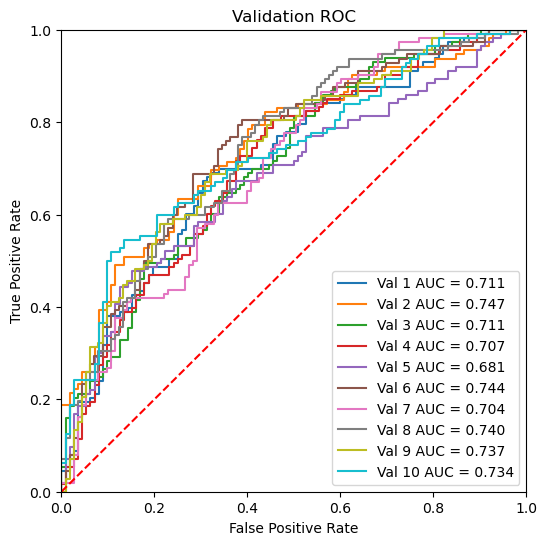

In [157]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('LSTM_WE_val.png')

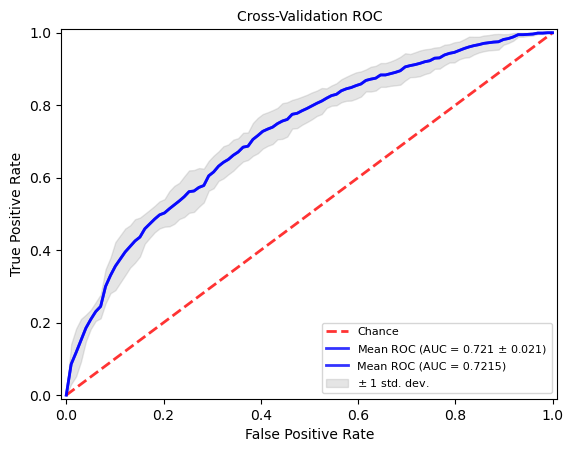

In [158]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('LSTM_WE_val_mean.png')
plt.show()

In [159]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [160]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)
my_calculate_metrics_list_val

[{'SN': 0.39823008849557523,
  'SP': 0.8482142857142857,
  'ACC': 0.6222222222222222,
  'MCC': 0.27578935220218664,
  'Recall': 0.39823008849557523,
  'Precision': 0.7258064516129032,
  'F1-score': 0.5142857142857142,
  'Cutoff': 0.5},
 {'SN': 0.6071428571428571,
  'SP': 0.75,
  'ACC': 0.6785714285714286,
  'MCC': 0.36084391824351614,
  'Recall': 0.6071428571428571,
  'Precision': 0.7083333333333334,
  'F1-score': 0.6538461538461539,
  'Cutoff': 0.5},
 {'SN': 0.5309734513274337,
  'SP': 0.75,
  'ACC': 0.64,
  'MCC': 0.2878802688280675,
  'Recall': 0.5309734513274337,
  'Precision': 0.6818181818181818,
  'F1-score': 0.5970149253731343,
  'Cutoff': 0.5},
 {'SN': 0.6637168141592921,
  'SP': 0.6428571428571429,
  'ACC': 0.6533333333333333,
  'MCC': 0.3066466536835476,
  'Recall': 0.6637168141592921,
  'Precision': 0.6521739130434783,
  'F1-score': 0.6578947368421053,
  'Cutoff': 0.5},
 {'SN': 0.7079646017699115,
  'SP': 0.5357142857142857,
  'ACC': 0.6222222222222222,
  'MCC': 0.2474216486

In [161]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.398230,0.848214,0.622222,0.275789,0.398230,0.725806,0.514286,0.5
1,0.607143,0.750000,0.678571,0.360844,0.607143,0.708333,0.653846,0.5
2,0.530973,0.750000,0.640000,0.287880,0.530973,0.681818,0.597015,0.5
3,0.663717,0.642857,0.653333,0.306647,0.663717,0.652174,0.657895,0.5
4,0.707965,0.535714,0.622222,0.247422,0.707965,0.606061,0.653061,0.5
5,0.687500,0.681416,0.684444,0.368916,0.687500,0.681416,0.684444,0.5
6,0.625000,0.637168,0.631111,0.262189,0.625000,0.630631,0.627803,0.5
7,0.660714,0.637168,0.648889,0.297953,0.660714,0.643478,0.651982,0.5
8,0.705357,0.619469,0.662222,0.325987,0.705357,0.647541,0.675214,0.5
9,0.651786,0.705357,0.678571,0.357656,0.651786,0.688679,0.669725,0.5


In [162]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.398230,0.848214,0.622222,0.275789,0.398230,0.725806,0.514286,0.5
1,0.607143,0.750000,0.678571,0.360844,0.607143,0.708333,0.653846,0.5
2,0.530973,0.750000,0.640000,0.287880,0.530973,0.681818,0.597015,0.5
3,0.663717,0.642857,0.653333,0.306647,0.663717,0.652174,0.657895,0.5
4,0.707965,0.535714,0.622222,0.247422,0.707965,0.606061,0.653061,0.5
5,0.687500,0.681416,0.684444,0.368916,0.687500,0.681416,0.684444,0.5
6,0.625000,0.637168,0.631111,0.262189,0.625000,0.630631,0.627803,0.5
7,0.660714,0.637168,0.648889,0.297953,0.660714,0.643478,0.651982,0.5
8,0.705357,0.619469,0.662222,0.325987,0.705357,0.647541,0.675214,0.5
9,0.651786,0.705357,0.678571,0.357656,0.651786,0.688679,0.669725,0.5


In [163]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\LSTM_OH_performance_val.csv',encoding='utf-8')

In [164]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [165]:
roc_auc_list_indep

[0.7285554846938775,
 0.7915338010204082,
 0.7408322704081634,
 0.7374840561224489,
 0.7015704719387755,
 0.7472895408163266,
 0.760124362244898,
 0.7059151785714285,
 0.750717474489796,
 0.6847895408163265]

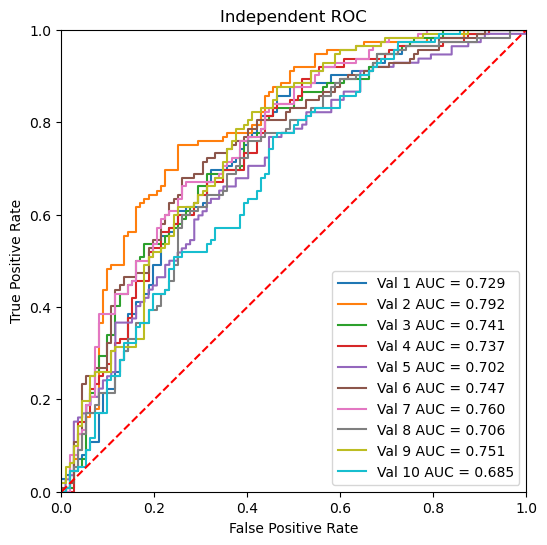

In [166]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('LSTM_WE_indep.png')
plt.show()

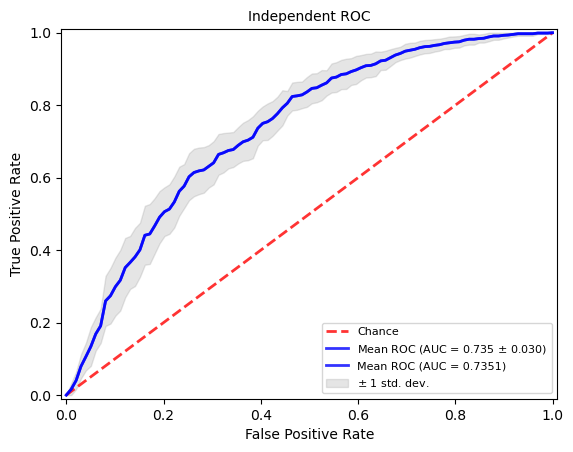

In [167]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('LSTM_WE_indep_mean.png')
plt.show()

In [168]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [169]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)
my_calculate_metrics_list_indep

[{'SN': 0.3392857142857143,
  'SP': 0.8571428571428571,
  'ACC': 0.5982142857142857,
  'MCC': 0.22961557339788813,
  'Recall': 0.3392857142857143,
  'Precision': 0.7037037037037037,
  'F1-score': 0.4578313253012048,
  'Cutoff': 0.5},
 {'SN': 0.6607142857142857,
  'SP': 0.7767857142857143,
  'ACC': 0.71875,
  'MCC': 0.4404772434759848,
  'Recall': 0.6607142857142857,
  'Precision': 0.7474747474747475,
  'F1-score': 0.7014218009478673,
  'Cutoff': 0.5},
 {'SN': 0.5803571428571429,
  'SP': 0.7410714285714286,
  'ACC': 0.6607142857142857,
  'MCC': 0.32566185911337303,
  'Recall': 0.5803571428571429,
  'Precision': 0.6914893617021277,
  'F1-score': 0.6310679611650486,
  'Cutoff': 0.5},
 {'SN': 0.6428571428571429,
  'SP': 0.7053571428571429,
  'ACC': 0.6741071428571429,
  'MCC': 0.34889639074744044,
  'Recall': 0.6428571428571429,
  'Precision': 0.6857142857142857,
  'F1-score': 0.663594470046083,
  'Cutoff': 0.5},
 {'SN': 0.7053571428571429,
  'SP': 0.5892857142857143,
  'ACC': 0.6473214285

In [170]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.339286,0.857143,0.598214,0.229616,0.339286,0.703704,0.457831,0.5
1,0.660714,0.776786,0.718750,0.440477,0.660714,0.747475,0.701422,0.5
2,0.580357,0.741071,0.660714,0.325662,0.580357,0.691489,0.631068,0.5
3,0.642857,0.705357,0.674107,0.348896,0.642857,0.685714,0.663594,0.5
4,0.705357,0.589286,0.647321,0.296648,0.705357,0.632000,0.666667,0.5
5,0.687500,0.705357,0.696429,0.392920,0.687500,0.700000,0.693694,0.5
6,0.669643,0.696429,0.683036,0.366203,0.669643,0.688073,0.678733,0.5
7,0.616071,0.687500,0.651786,0.304349,0.616071,0.663462,0.638889,0.5
8,0.633929,0.705357,0.669643,0.340155,0.633929,0.682692,0.657407,0.5
9,0.571429,0.669643,0.620536,0.242243,0.571429,0.633663,0.600939,0.5


In [171]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.339286,0.857143,0.598214,0.229616,0.339286,0.703704,0.457831,0.5
1,0.660714,0.776786,0.718750,0.440477,0.660714,0.747475,0.701422,0.5
2,0.580357,0.741071,0.660714,0.325662,0.580357,0.691489,0.631068,0.5
3,0.642857,0.705357,0.674107,0.348896,0.642857,0.685714,0.663594,0.5
4,0.705357,0.589286,0.647321,0.296648,0.705357,0.632000,0.666667,0.5
5,0.687500,0.705357,0.696429,0.392920,0.687500,0.700000,0.693694,0.5
6,0.669643,0.696429,0.683036,0.366203,0.669643,0.688073,0.678733,0.5
7,0.616071,0.687500,0.651786,0.304349,0.616071,0.663462,0.638889,0.5
8,0.633929,0.705357,0.669643,0.340155,0.633929,0.682692,0.657407,0.5
9,0.571429,0.669643,0.620536,0.242243,0.571429,0.633663,0.600939,0.5


In [172]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_OH\result\LSTM_OH_performance_indep.csv',encoding='utf-8')

In [173]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

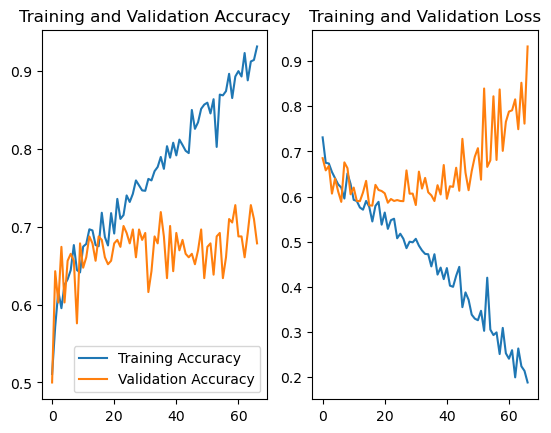

In [174]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()